## Timeseries Augmentation

**THIS IS NOT THE FINAL MODEL**

This notebook is included for integrity as it shows the implementation of our second Data Augmentation implementation. Conceptually the cells to be considered are in the Exploration Data Analysis section. The others are related to the ensemble method as described in the report.

### Connect to Drive

In [1]:
from google.colab import drive
drive.mount('/gdrive')

Mounted at /gdrive


In [2]:
%cd /gdrive/My Drive/Colab Notebooks/Homework2

/gdrive/My Drive/Colab Notebooks/Homework2


In [3]:
!pip install tsaug

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


### Import libraries

In [4]:
import tensorflow as tf
import numpy as np
import os
import random
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import train_test_split
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from collections import Counter
from random import shuffle
import pickle
import warnings
import logging


plt.rc('font', size=16) 
tfk = tf.keras
tfkl = tf.keras.layers
print(tf.__version__)

tfk = tf.keras
tfkl = tf.keras.layers
print(tf.__version__)

2.9.2
2.9.2


### Set seed for reproducibility

In [5]:
# Random seed for reproducibility
seed = 42

random.seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)

### Exploration Data Analysis (EDA)

In [6]:
x_dataset = np.load('x_train.npy')
y_dataset = np.load('y_train.npy')

In [7]:
import pickle
from sklearn.preprocessing import RobustScaler

scaler = RobustScaler()
x_dataset = scaler.fit_transform(x_dataset.reshape(-1, x_dataset.shape[-1])).reshape(x_dataset.shape)

file = open('scaler', 'wb')
pickle.dump(scaler, file)
file.close()

In [8]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test_val = train_test_split(x_dataset, y_dataset, test_size=0.2, stratify=y_dataset)
print(x_train.shape)
print(y_train.shape)

# print('y_dataset:', Counter(y_dataset))
# print('y_train_da:', Counter(y_train))
# x_val=x_test
# y_val=y_test

from sklearn.model_selection import train_test_split
x_test_da, x_val_da, y_test_da, y_val_da = train_test_split(x_test, y_test_val, test_size=0.5, stratify=y_test_val)
print(x_test_da.shape)
print(y_test_da.shape)
print(x_val_da.shape)
print(y_val_da.shape)
print('y_test_da:', Counter(y_test_da))
print('y_val_da:', Counter(y_val_da))

(1943, 36, 6)
(1943,)
(243, 36, 6)
(243,)
(243, 36, 6)
(243,)
y_test_da: Counter({9: 78, 3: 38, 6: 31, 2: 27, 5: 16, 8: 12, 1: 12, 7: 7, 10: 7, 4: 6, 11: 5, 0: 4})
y_val_da: Counter({9: 77, 3: 38, 6: 32, 2: 27, 5: 15, 1: 13, 8: 12, 10: 8, 7: 7, 4: 6, 11: 5, 0: 3})


In [9]:
def oversampling(x_train, y_train_da):

  print(x_train.shape)
  shape_x = x_train.shape[0]
  
  warnings.filterwarnings(action='ignore', category=DeprecationWarning)
  ratio = {
            0 : ( (int) (Counter(y_train_da)[0] * 3.0)),
            1 : ( (int) (Counter(y_train_da)[1] * 1.2)),
            2 : ( (int) (Counter(y_train_da)[2] * 1.15)),
            3 : ( (int) (Counter(y_train_da)[3] * 1.25)),
            4 : ( (int) (Counter(y_train_da)[4] * 2.0)),
            5 : ( (int) (Counter(y_train_da)[5] * 1.2)),
            6 : ( (int) (Counter(y_train_da)[6] * 1.0)),
            7 : ( (int) (Counter(y_train_da)[7] * 1.75)),
            8 : ( (int) (Counter(y_train_da)[8] * 1.2)),
            9 : ( (int) (Counter(y_train_da)[9] * 1.0)),
            10 : ( (int) (Counter(y_train_da)[10] * 1.7)),
            11 : ( (int) (Counter(y_train_da)[11] * 2.0))  
           }
  count = 0
  for i in ratio.values():
    count += i
  #sampling_strategy=ratio
  sm = SMOTE(sampling_strategy=ratio)

  X_train_scaled_resahaped = x_train.reshape((-1, x_train.shape[0]))
  #X_train_scaled_resahaped = X_train_scaled_resahaped.transpose()
  X_train_scaled_resahaped = X_train_scaled_resahaped.reshape((shape_x, 216))


  ### Resample X_train_scaled
  X_train_resampled, y_train_resampled = sm.fit_resample(X_train_scaled_resahaped, y_train_da)
  print(X_train_resampled.shape)
  print(y_train_resampled.shape)
  #x_dataset = X_train_resampled.reshape((count, 36, 6))
  x_dataset = X_train_resampled.reshape((X_train_resampled.shape[0], 36, 6))
  print(x_dataset.shape)

  print('Original dataset shape:', Counter(y_train_da))
  print('Resampled dataset shape:', Counter(y_train_resampled))
  print(y_train_resampled.shape)

  return x_dataset, y_train_resampled

In [10]:
x_train, y_train_dacat = oversampling(x_train, y_train)


y_train = tfk.utils.to_categorical(y_train_dacat)
y_val = tfk.utils.to_categorical(y_val_da)
y_test = tfk.utils.to_categorical(y_test_da)

# ind_list = [i for i in range(x_train.shape[0])]
# shuffle(ind_list)
# x_train = x_train[ind_list]
# y_train = y_train[ind_list]

# ind_list = [i for i in range(x_val.shape[0])]
# shuffle(ind_list)
# x_val_da = x_val[ind_list]
# y_val = y_val[ind_list]

# ind_list = [i for i in range(x_test_da.shape[0])]
# shuffle(ind_list)
# x_test_da = x_test_da[ind_list]
# y_test = y_test[ind_list]

(1943, 36, 6)
(2341, 216)
(2341,)
(2341, 36, 6)
Original dataset shape: Counter({9: 622, 3: 305, 6: 250, 2: 216, 5: 122, 1: 98, 8: 96, 10: 62, 7: 54, 4: 50, 11: 41, 0: 27})
Resampled dataset shape: Counter({9: 622, 3: 381, 6: 250, 2: 248, 5: 146, 1: 117, 8: 115, 10: 105, 4: 100, 7: 94, 11: 82, 0: 81})
(2341,)


In [11]:
from tsaug import TimeWarp, Crop, Quantize, Drift, Reverse
my_augmenter = (
     #TimeWarp() * 5  # random time warping 5 times in parallel
     Crop(size=36)  # random crop subsequences with length 300
     + Quantize(n_levels=[10, 20, 30])  # random quantize to 10-, 20-, or 30- level sets
     + Drift(max_drift=(0.1, 0.5)) @ 0.8  # with 80% probability, random drift the signal up to 10% - 50%
     + Reverse() @ 0.5  # with 50% probability, reverse the sequence
 )

In [12]:
labels=[]
augs=np.copy(x_train)
for i in range(x_train.shape[0]):
  elem=x_train[i,:,:]
  #print(elem.shape)
  dummy_batch=np.expand_dims(elem, axis=0)
  x_aug=my_augmenter.augment(dummy_batch)
  #print(x_aug.shape)
  label=y_train[i]
  labels.append(label)
  augs=np.append(augs,x_aug,axis=0)
y_train=np.concatenate((y_train,labels),axis=0)
x_train=augs

### Build and train models

In [13]:
input_shape = x_train.shape[1:]
classes = y_train.shape[-1]
batch_size = 128
units = 512

# Map activities to integers
label_mapping = {
    'Wish': 0,
    'Another': 1,
    'Comfortably': 2,
    'Money': 3,
    'Breathe': 4,
    'Time': 5,
    'Brain': 6,
    'Echoes': 7,
    'Wearing': 8,
    'Sorrow': 9,
    'Hey': 10,
    'Shine': 11
}

#### Vanilla Long Short Term Memory (LSTM) Neural Network

![](https://drive.google.com/uc?export=view&id=1FZ_P4SgVAA_mCZQ0tK18VwRqGqzNANOE
)

tf.keras.layers.LSTM(
    units,
    activation='tanh',
    recurrent_activation='sigmoid',
    use_bias=True,
    kernel_initializer='glorot_uniform',
    recurrent_initializer='orthogonal',
    bias_initializer='zeros',
    unit_forget_bias=True,
    kernel_regularizer=None,
    recurrent_regularizer=None,
    bias_regularizer=None,
    activity_regularizer=None,
    kernel_constraint=None,
    recurrent_constraint=None,
    bias_constraint=None,
    dropout=0.0,
    recurrent_dropout=0.0,
    return_sequences=False,
    return_state=False,
    go_backwards=False,
    stateful=False,
    time_major=False,
    unroll=False,
    **kwargs
)

In [14]:
def build_LSTM_classifier(input_shape, classes):
    # Build the neural network layer by layer
    input_layer = tfkl.Input(shape=input_shape, name='Input')

    #noise = tf.keras.layers.GaussianNoise(0.05)(input_layer)

    # Feature extractor
    lstm = tfkl.LSTM(units, return_sequences=True)(input_layer)
    lstm = tfkl.Dropout(.3, seed=seed)(lstm)
    lstm = tfkl.LSTM(units,return_sequences=True)(lstm)
    lstm = tfkl.Dropout(.3, seed=seed)(lstm)
    lstm = tfkl.LSTM(units, return_sequences=True)(lstm)
    lstm = tfkl.Dropout(.3, seed=seed)(lstm)
    
    lstm = tfkl.LSTM(units)(lstm)
    
    lstm = tfkl.Dense(512, activation='relu')(lstm)
    lstm = tfkl.Dense(512, activation='relu')(lstm)
    lstm = tfkl.Dense(512, activation='relu')(lstm)

    output_layer = tfkl.Dense(classes, activation='softmax')(lstm)

    # Connect input and output through the Model class
    model = tfk.Model(inputs=input_layer, outputs=output_layer, name='model')

    # Compile the model
    model.compile(loss=tfk.losses.CategoricalCrossentropy(), optimizer=tfk.optimizers.Adam(), metrics='accuracy')
    return model

def build_RNN_classifier(input_shape, classes):
    # Build the neural network layer by layer
    input_layer = tfkl.Input(shape=input_shape, name='Input')

    #noise = tf.keras.layers.GaussianNoise(0.05)(input_layer)

    # Feature extractor
    rnn = tfkl.SimpleRNN(units, return_sequences=True)(input_layer)
    rnn = tfkl.Dropout(.6, seed=seed)(rnn)
    rnn = tfkl.SimpleRNN(units, return_sequences=True)(rnn)
    rnn = tfkl.Dropout(.6, seed=seed)(rnn)

    rnn = tfkl.GRU(units, return_sequences=True)(input_layer)
    rnn = tfkl.Dropout(.6, seed=seed)(rnn)
    rnn = tfkl.GRU(units, return_sequences=True)(rnn)
    rnn = tfkl.Dropout(.6, seed=seed)(rnn)

    rnn = tfkl.SimpleRNN(units, return_sequences=False)(rnn)
    rnn = tfkl.Dropout(0.6, seed=seed)(rnn)

    rnn = tfkl.Dense(512, activation='relu')(rnn)
    rnn = tfkl.Dense(512, activation='relu')(rnn)
    rnn = tfkl.Dense(512, activation='relu')(rnn)

    output_layer = tfkl.Dense(classes, activation='softmax')(rnn)

    # Connect input and output through the Model class
    model = tfk.Model(inputs=input_layer, outputs=output_layer, name='model')

    # Compile the model
    model.compile(loss=tfk.losses.CategoricalCrossentropy(), optimizer=tfk.optimizers.Adam(), metrics='accuracy')
    return model



def build_BiLSTM_classifier(input_shape, classes):
    # Build the neural network layer by layer
    input_layer = tfkl.Input(shape=input_shape, name='Input')

    # Feature extractor
    bilstm = tfkl.Bidirectional(tfkl.LSTM(units, return_sequences=True))(input_layer)

    bilstm = tfkl.Dropout(.6, seed=seed)(bilstm)

    bilstm = tfkl.Bidirectional(tfkl.LSTM(units, return_sequences=True))(bilstm)
    bilstm = tfkl.Dropout(.6, seed=seed)(bilstm)

    bilstm = tfkl.Bidirectional(tfkl.LSTM(units))(bilstm)

    bilstm = tfkl.Dropout(.6, seed=seed)(bilstm)

    # Classifier
    bilstm = tfkl.Dense(512, activation='relu')(bilstm)
    bilstm = tfkl.Dense(512, activation='relu')(bilstm)
    bilstm = tfkl.Dense(512, activation='relu')(bilstm)
    output_layer = tfkl.Dense(classes, activation='softmax')(bilstm)

    # Connect input and output through the Model class
    model = tfk.Model(inputs=input_layer, outputs=output_layer, name='model')

    # Compile the model
    model.compile(loss=tfk.losses.CategoricalCrossentropy(), optimizer=tfk.optimizers.Adam(), metrics='accuracy')
    return model




def build_1DCNN_classifier(input_shape, classes):
    # Build the neural network layer by layer
    input_layer = tfkl.Input(shape=input_shape, name='Input')

    cnn = tfkl.Conv1D(units,3,padding='same',activation='relu')(input_layer)
    cnn = tfkl.MaxPooling1D()(cnn)
    cnn = tfkl.Dropout(.3, seed=seed)(cnn)

    cnn = tfkl.Conv1D(units,3,padding='same',activation='relu')(cnn)
    cnn = tfkl.MaxPooling1D()(cnn)
    cnn = tfkl.Dropout(.3, seed=seed)(cnn)

    cnn = tfkl.Conv1D(units,3,padding='same',activation='relu')(cnn)
    cnn = tfkl.MaxPooling1D()(cnn)
    cnn = tfkl.Dropout(.3, seed=seed)(cnn)

    cnn = tfkl.Conv1D(units,3,padding='same',activation='relu')(cnn)
    cnn = tfkl.GlobalAveragePooling1D()(cnn)
    cnn = tfkl.Dropout(.5, seed=seed)(cnn)

    # Classifier
    
    cnn = tfkl.Dense(512, activation='relu')(cnn)
    cnn = tfkl.Dense(512, activation='relu')(cnn)
    cnn = tfkl.Dense(512, activation='relu')(cnn)
    output_layer = tfkl.Dense(classes, activation='softmax')(cnn)

    # Connect input and output through the Model class
    model = tfk.Model(inputs=input_layer, outputs=output_layer, name='model')

    # Compile the model
    model.compile(loss=tfk.losses.CategoricalCrossentropy(), optimizer=tfk.optimizers.Adam(), metrics='accuracy')
    return model


def build_CNN_BILSTM_classifier(input_shape, classes):
    # Build the neural network layer by layer
    input_layer = tfkl.Input(shape=input_shape, name='Input')
    
    cnn = tfkl.Conv1D(units,3,padding='same',activation='relu')(input_layer)
    cnn = tfkl.MaxPooling1D()(cnn)
    cnn = tfkl.Dropout(.4, seed=seed)(cnn)

    cnn = tfkl.Conv1D(units,3,padding='same',activation='relu')(cnn)
    cnn = tfkl.MaxPooling1D()(cnn)
    cnn = tfkl.Dropout(.4, seed=seed)(cnn)

    cnn = tfkl.Bidirectional(tfkl.LSTM((int)(units),return_sequences=True))(cnn)
    cnn = tfkl.Dropout(.4, seed=seed)(cnn)
    cnn = tfkl.Bidirectional(tfkl.LSTM((int)(units),return_sequences=True))(cnn)
    
    cnn = tfkl.GlobalAveragePooling1D()(cnn)
    cnn = tfkl.Dropout(.5, seed=seed)(cnn)
    # Classifier
    
    cnn = tfkl.Dense(512, activation='relu')(cnn)
    cnn = tfkl.Dense(512, activation='relu')(cnn)
    cnn = tfkl.Dense(512, activation='relu')(cnn)


    output_layer = tfkl.Dense(classes, activation='softmax')(cnn)

    # Connect input and output through the Model class
    model = tfk.Model(inputs=input_layer, outputs=output_layer, name='model')

    # Compile the model
    model.compile(loss=tfk.losses.CategoricalCrossentropy(), optimizer=tfk.optimizers.Adam(), metrics='accuracy')

    # Return the model
    return model

Epoch 1/100
37/37 [==============================] - 13s 110ms/step - loss: 1.9871 - accuracy: 0.3246 - val_loss: 1.5114 - val_accuracy: 0.4856 - lr: 0.0010
Epoch 2/100
37/37 [==============================] - 3s 68ms/step - loss: 1.6869 - accuracy: 0.4250 - val_loss: 1.5131 - val_accuracy: 0.4979 - lr: 0.0010
Epoch 3/100
37/37 [==============================] - 3s 68ms/step - loss: 1.5663 - accuracy: 0.4607 - val_loss: 1.3399 - val_accuracy: 0.5391 - lr: 0.0010
Epoch 4/100
37/37 [==============================] - 3s 68ms/step - loss: 1.4847 - accuracy: 0.4859 - val_loss: 1.3066 - val_accuracy: 0.5062 - lr: 0.0010
Epoch 5/100
37/37 [==============================] - 3s 69ms/step - loss: 1.3802 - accuracy: 0.5216 - val_loss: 1.2399 - val_accuracy: 0.5761 - lr: 0.0010
Epoch 6/100
37/37 [==============================] - 3s 68ms/step - loss: 1.3457 - accuracy: 0.5416 - val_loss: 1.2685 - val_accuracy: 0.5556 - lr: 0.0010
Epoch 7/100
37/37 [==============================] - 3s 72ms/step - 

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


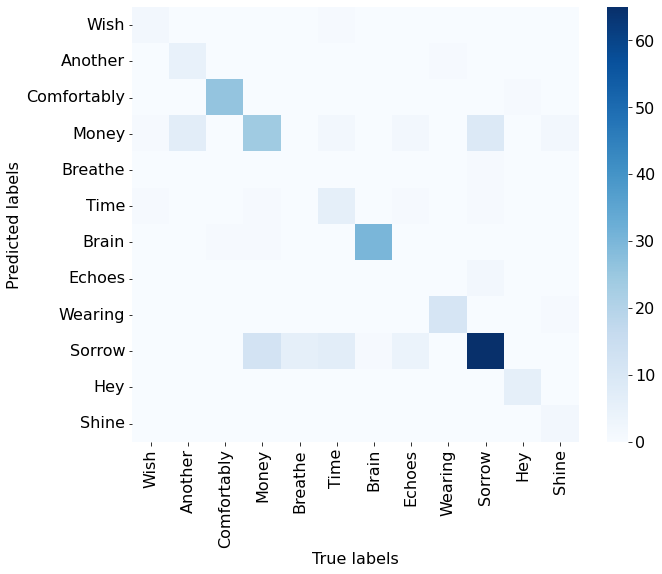

In [15]:
# train models and keep them in memory
models = list()

model = build_LSTM_classifier(input_shape, classes)
models.append(model)

model = build_RNN_classifier(input_shape, classes)
models.append(model)

model = build_BiLSTM_classifier(input_shape, classes)
models.append(model)

model = build_1DCNN_classifier(input_shape, classes)
models.append(model)

model = build_CNN_BILSTM_classifier(input_shape, classes)
models.append(model)


epochs = 100


for i in range(len(models)):
  history = models[i].fit(
    x = x_train,
    y = y_train,
    batch_size = batch_size,
    shuffle=True,
    epochs = epochs,
    validation_data = (x_val_da,y_val),
    callbacks = [
        tfk.callbacks.EarlyStopping(monitor='val_accuracy', mode='max', patience=20, restore_best_weights=True),
        tfk.callbacks.ReduceLROnPlateau(monitor='val_accuracy', mode='max', patience=10, factor=0.5, min_lr=1e-5)
        ]
    ).history

  best_epoch = np.argmax(history['val_accuracy'])
  print('Modello ',i,' best epoch: ',best_epoch,' -> ',max(history['accuracy']),' ',max(history['val_accuracy']) )


yhats = [model.predict(x_test_da) for model in models]
yhats = np.array(yhats)

for i in range(len(yhats)):
  accuracy = accuracy_score(np.argmax(y_test, axis=-1), np.argmax(yhats[i], axis=-1))
  precision = precision_score(np.argmax(y_test, axis=-1), np.argmax(yhats[i], axis=-1), average='macro')
  recall = recall_score(np.argmax(y_test, axis=-1), np.argmax(yhats[i], axis=-1), average='macro')
  f1 = f1_score(np.argmax(y_test, axis=-1), np.argmax(yhats[i], axis=-1), average='macro')
  print(i,':')
  print('Accuracy:',accuracy.round(4))
  print('Precision:',precision.round(4))
  print('Recall:',recall.round(4))
  print('F1:',f1.round(4))

predictions = np.mean(yhats, axis=0)

# Compute the classification metrics
accuracy = accuracy_score(np.argmax(y_test, axis=-1), np.argmax(predictions, axis=-1))
#accuracy = accuracy_score(np.argmax(y_test, axis=-1), predictions)
precision = precision_score(np.argmax(y_test, axis=-1), np.argmax(predictions, axis=-1), average='macro')
recall = recall_score(np.argmax(y_test, axis=-1), np.argmax(predictions, axis=-1), average='macro')
f1 = f1_score(np.argmax(y_test, axis=-1), np.argmax(predictions, axis=-1), average='macro')
print('\n\nENSEMBLE:')
print('Accuracy:',accuracy.round(4))
print('Precision:',precision.round(4))
print('Recall:',recall.round(4))
print('F1:',f1.round(4))


# Compute and plot the confusion matrix
cm = confusion_matrix(np.argmax(y_test, axis=-1), np.argmax(predictions, axis=-1))
plt.figure(figsize=(10,8))
sns.heatmap(cm.T, cmap='Blues', xticklabels=list(label_mapping.keys()), yticklabels=list(label_mapping.keys()))
plt.xlabel('True labels')
plt.ylabel('Predicted labels')
plt.show()

In [16]:
# models[0].save('model_0_6913')
# models[1].save('model_1_6975')
# models[2].save('model_2_743')
# models[3].save('model_3_7469')
# models[4].save('model_4_726')